# ICL vs Non-ICL Performance Comparison

This notebook compares model performance with and without in-context learning (ICL) examples across three relational complexity levels:
- **C1 (Q2)**: Constitutional Isomer Set Classification - Metric: Accuracy
- **C2 (Q1a)**: Largest Common Motif - Metric: Is Substructure
- **C3 (Q3)**: Missing Constitutional Isomers - Metric: Recall

In [24]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import rdFMCS

# Set style for plots - clean, no grid
sns.set_style("white")
plt.rcParams['figure.figsize'] = (18, 6)
plt.rcParams['font.size'] = 12

# Colors matching plot_relational_complexity.ipynb
custom_colors = ['#FFC1AD', '#FF6B35', '#CC4B24']  # Light orange, Orange, Dark orange

## Helper Functions

In [25]:
def load_results(file_path, model_name, icl_status):
    """Load results from a JSONL file and add model name and ICL status"""
    results = []
    
    if not Path(file_path).exists():
        print(f"Warning: {file_path} not found, skipping...")
        return results
    
    # Check if file is empty
    if Path(file_path).stat().st_size == 0:
        print(f"Warning: {file_path} is empty, skipping...")
        return results
    
    with open(file_path, 'r') as f:
        for line in f:
            result = json.loads(line)
            result['model_name'] = model_name
            result['icl'] = icl_status
            results.append(result)
    
    return results

def get_num_atoms(smiles):
    """Get number of heavy atoms in molecule"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return mol.GetNumHeavyAtoms()

def is_substructure(query_smiles, target_smiles):
    """Check if query is a substructure of target"""
    query_mol = Chem.MolFromSmiles(query_smiles)
    target_mol = Chem.MolFromSmiles(target_smiles)
    
    if query_mol is None or target_mol is None:
        return False
    
    return target_mol.HasSubstructMatch(query_mol)

def calculate_overlap_metric(response_smiles, correct_smiles):
    """Calculate atom overlap metric: N_overlap / max(N_response, N_correct)"""
    response_mol = Chem.MolFromSmiles(response_smiles)
    correct_mol = Chem.MolFromSmiles(correct_smiles)
    
    if response_mol is None or correct_mol is None:
        return 0.0
    
    n_response = response_mol.GetNumHeavyAtoms()
    n_correct = correct_mol.GetNumHeavyAtoms()
    
    if correct_mol.HasSubstructMatch(response_mol):
        n_overlap = n_response
    elif response_mol.HasSubstructMatch(correct_mol):
        n_overlap = n_correct
    else:
        mcs = rdFMCS.FindMCS([response_mol, correct_mol], timeout=5)
        if mcs.smartsString:
            mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
            if mcs_mol:
                n_overlap = mcs_mol.GetNumHeavyAtoms()
            else:
                n_overlap = 0
        else:
            n_overlap = 0
    
    max_atoms = max(n_response, n_correct)
    if max_atoms == 0:
        return 0.0
    
    return n_overlap / max_atoms

## C1 (Q2): Constitutional Isomer Set Classification

Metric: **Accuracy**

In [26]:
# Load C1 (Q2) results
c1_results = []

# First, load ICL results and collect question IDs
icl_question_ids = set()

c1_run_files_icl = [
    ('claude-opus-4-5', 'runs/claude-opus-4-5-20251101_icl_parallel/q2_icl.jsonl'),
    ('gpt-5.2', 'runs/gpt-5.2_icl_parallel/q2_icl.jsonl'),
    ('gemini-3-pro-preview', 'runs/gemini-3-pro-preview_icl_parallel/q2_icl.jsonl'),
]

for model, file_path in c1_run_files_icl:
    results = load_results(file_path, model, 'icl')
    for res in results:
        icl_question_ids.add(res['id'])
        c1_results.append([model, res['n_molecules'], res['score']['correct'], 'ICL'])

print(f"Found {len(icl_question_ids)} unique ICL question IDs for C1")

# Now load non-ICL results, filtering to matching IDs only
c1_run_files_no_icl = [
    ('claude-opus-4-5', 'runs/claude-opus-4-5-20251101_parallel/q2_isomer_set_yes_no_q2_balanced.jsonl'),
    ('gpt-5.2', 'runs/gpt-5.2_parallel/q2_isomer_set_yes_no_q2_balanced.jsonl'),
    ('gemini-3-pro-preview', 'runs/gemini-3-pro-preview_parallel/q2_isomer_set_yes_no_q2_balanced.jsonl'),
]

no_icl_count = 0
for model, file_path in c1_run_files_no_icl:
    results = load_results(file_path, model, 'no_icl')
    for res in results:
        if res['id'] in icl_question_ids:
            c1_results.append([model, res['n_molecules'], res['score']['correct'], 'No ICL'])
            no_icl_count += 1

print(f"Filtered to {no_icl_count} matching non-ICL questions for C1")

c1_df = pd.DataFrame(c1_results, columns=['Model', 'n_molecules', 'correct', 'ICL'])
c1_df['n_mol_bin'] = pd.cut(c1_df['n_molecules'], bins=[0, 19, 39, 60], labels=['<20', '20-40', '>=40'])
c1_df_agg = c1_df.groupby(['Model', 'n_mol_bin', 'ICL'], observed=True).agg({'correct': 'mean'}).reset_index()
c1_df_agg['Task'] = 'C1'
c1_df_agg.rename(columns={'correct': 'Task Completion'}, inplace=True)

print(f"\nLoaded {len(c1_df)} C1 (Q2) results total")
print(f"\nC1 Summary by ICL:")
print(c1_df_agg.groupby('ICL')['Task Completion'].mean())

Found 100 unique ICL question IDs for C1
Filtered to 300 matching non-ICL questions for C1

Loaded 600 C1 (Q2) results total

C1 Summary by ICL:
ICL
ICL       0.770370
No ICL    0.703704
Name: Task Completion, dtype: float64


## C2 (Q1a): Largest Common Motif

Metric: **Is Substructure** (average of response_is_substructure_of_correct and correct_is_substructure_of_response)

In [27]:
# Load the dataset to get ground truth
dataset = []
with open('data/dataset_q1a_fixed_smiles.jsonl', 'r') as f:
    for line in f:
        dataset.append(json.loads(line))

q1a_dataset = [d for d in dataset if d['task'] == 'q1a_largest_common_motif_chembl']
dataset_lookup = {d['id']: d for d in q1a_dataset}

print(f"Total Q1a instances in dataset: {len(q1a_dataset)}")

# First, load ICL results and collect question IDs
icl_question_ids_c2 = set()

c2_run_files_icl = [
    ('claude-opus-4-5', 'runs/claude-opus-4-5-20251101_icl_parallel/q1a_icl.jsonl'),
    ('gpt-5.2', 'runs/gpt-5.2_icl_parallel/q1a_icl.jsonl'),
    ('gemini-3-pro-preview', 'runs/gemini-3-pro-preview_icl_parallel/q1a_icl.jsonl'),
]

all_results = []

# Load ICL results and collect IDs
for model_name, file_path in c2_run_files_icl:
    results = load_results(file_path, model_name, 'icl')
    for result in results:
        result['icl_label'] = 'ICL'
        icl_question_ids_c2.add(result['id'])
        all_results.append(result)

print(f"Found {len(icl_question_ids_c2)} unique ICL question IDs for C2")

# Now load non-ICL results, filtering to matching IDs only
c2_run_files_no_icl = [
    ('claude-opus-4-5', 'runs/claude-opus-4-5-20251101_parallel/q1a_largest_common_motif_chembl_q1a_fixed_smiles.jsonl'),
    ('gpt-5.2', 'runs/gpt-5.2_parallel/q1a_largest_common_motif_chembl_q1a_fixed_smiles.jsonl'),
    ('gemini-3-pro-preview', 'runs/gemini-3-pro-preview_parallel/q1a_largest_common_motif_chembl_q1a_fixed_smiles.jsonl'),
]

no_icl_count_c2 = 0
for model_name, file_path in c2_run_files_no_icl:
    results = load_results(file_path, model_name, 'no_icl')
    for result in results:
        if result['id'] in icl_question_ids_c2:
            result['icl_label'] = 'No ICL'
            all_results.append(result)
            no_icl_count_c2 += 1

print(f"Filtered to {no_icl_count_c2} matching non-ICL questions for C2")

# Enrich results with substructure metrics
enriched_results = []

for result in all_results:
    instance_id = result['id']
    
    if instance_id not in dataset_lookup:
        continue
    
    correct_smiles = result['score'].get('gold_canonical') or result['score'].get('gold')
    response_smiles = result['score'].get('pred_canonical') or result['score'].get('pred')
    
    if response_smiles is None:
        response_is_sub = False
        correct_is_sub = False
    else:
        response_is_sub = is_substructure(response_smiles, correct_smiles) if correct_smiles else False
        correct_is_sub = is_substructure(correct_smiles, response_smiles) if correct_smiles else False
    
    enriched_results.append({
        'model': result['model_name'],
        'n_molecules': result['n_molecules'],
        'response_is_substructure_of_correct': response_is_sub,
        'correct_is_substructure_of_response': correct_is_sub,
        'icl': result['icl_label']
    })

# Convert to DataFrame and calculate is_substructure metric
c2_df = pd.DataFrame(enriched_results)
c2_df['n_mol_bin'] = pd.cut(c2_df['n_molecules'], bins=[0, 19, 39, 60], labels=['<20', '20-40', '>=40'])

c2_df_agg = c2_df.groupby(['model', 'n_mol_bin', 'icl'], observed=True).agg({
    'response_is_substructure_of_correct': 'mean',
    'correct_is_substructure_of_response': 'mean'
}).reset_index()

c2_df_agg['is_substructure'] = 0.5 * (
    c2_df_agg['correct_is_substructure_of_response'] + 
    c2_df_agg['response_is_substructure_of_correct']
)

c2_df_final = c2_df_agg[['model', 'n_mol_bin', 'icl', 'is_substructure']].copy()
c2_df_final['Task'] = 'C2'
c2_df_final.rename(columns={'is_substructure': 'Task Completion', 'model': 'Model', 'icl': 'ICL'}, inplace=True)

print(f"\nLoaded {len(c2_df)} C2 (Q1a) results total")
print(f"\nC2 Summary by ICL:")
print(c2_df_final.groupby('ICL')['Task Completion'].mean())

Total Q1a instances in dataset: 1016
Found 100 unique ICL question IDs for C2
Filtered to 300 matching non-ICL questions for C2

Loaded 400 C2 (Q1a) results total

C2 Summary by ICL:
ICL
ICL       0.433333
No ICL    0.399074
Name: Task Completion, dtype: float64


[20:21:52] SMILES Parse Error: unclosed ring for input: 'NCC1OC(OC2C(N)CC(N)C(OC3OC(CO)C(O)C(N)C3O)C2O)C'
[20:21:52] SMILES Parse Error: unclosed ring for input: 'NCC1OC(OC2C(N)CC(N)C(OC3OC(CO)C(O)C(N)C3O)C2O)C'
[20:21:52] SMILES Parse Error: unclosed ring for input: 'CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(OC2OC(C)CC(N(C)C)C2O)C(C)(O)CC(C)C'
[20:21:52] SMILES Parse Error: unclosed ring for input: 'CCC1OC(=O)C(C)C(OC2CC(C)(OC)C(O)C(C)O2)C(C)C(OC2OC(C)CC(N(C)C)C2O)C(C)(O)CC(C)C'
[20:21:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7
[20:21:52] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 7
[20:21:52] SMILES Parse Error: unclosed ring for input: 'CC12CCC(=O)C=C1CCC1C2CCC2(C)C1CCC2C3CCC4=CC(=O)CCC4(C)C3CC21C'
[20:21:52] SMILES Parse Error: unclosed ring for input: 'CC12CCC(=O)C=C1CCC1C2CCC2(C)C1CCC2C3CCC4=CC(=O)CCC4(C)C3CC21C'
[20:21:52] SMILES Parse Error: unclosed ring for input: 'O=C1C=CC2CCC3CCCC23'
[20:21:52] SMILES Parse Error: unclosed ring for input: 'O=C1C=CC2CCC3CC

## C3 (Q3): Missing Constitutional Isomers

Metric: **Recall**

In [28]:
# Load C3 (Q3) results
c3_results = []

# First, load ICL results and collect question IDs
icl_question_ids_c3 = set()

c3_run_files_icl = [
    ('claude-opus-4-5', 'runs/claude-opus-4-5-20251101_icl_parallel/q3_icl.jsonl'),
    ('gpt-5.2', 'runs/gpt-5.2_icl_parallel/q3_icl.jsonl'),
    ('gemini-3-pro-preview', 'runs/gemini-3-pro-preview_icl_parallel/q3_icl.jsonl'),
]

for model_name, file_path in c3_run_files_icl:
    results = load_results(file_path, model_name, 'icl')
    for result in results:
        icl_question_ids_c3.add(result['id'])
        c3_results.append([model_name, result['n_molecules'], result['score']['recall'], 'ICL'])

print(f"Found {len(icl_question_ids_c3)} unique ICL question IDs for C3")

# Now load non-ICL results, filtering to matching IDs only
c3_run_files_no_icl = [
    ('claude-opus-4-5', 'runs/claude-opus-4-5-20251101_parallel/q3_missing_isomers.jsonl'),
    ('gpt-5.2', 'runs/gpt-5.2_parallel/q3_missing_isomers.jsonl'),
    ('gemini-3-pro-preview', 'runs/gemini-3-pro-preview_parallel/q3_missing_isomers_v2.jsonl'),
]

no_icl_count_c3 = 0
for model_name, file_path in c3_run_files_no_icl:
    results = load_results(file_path, model_name, 'no_icl')
    for result in results:
        if result['id'] in icl_question_ids_c3:
            c3_results.append([model_name, result['n_molecules'], result['score']['recall'], 'No ICL'])
            no_icl_count_c3 += 1

print(f"Filtered to {no_icl_count_c3} matching non-ICL questions for C3")

c3_df = pd.DataFrame(c3_results, columns=['Model', 'n_molecules', 'recall', 'ICL'])
c3_df['n_mol_bin'] = pd.cut(c3_df['n_molecules'], bins=[0, 19, 39, 60], labels=['<20', '20-40', '>=40'])
c3_df_agg = c3_df.groupby(['Model', 'n_mol_bin', 'ICL'], observed=True).agg({'recall': 'mean'}).reset_index()
c3_df_agg['Task'] = 'C3'
c3_df_agg.rename(columns={'recall': 'Task Completion'}, inplace=True)

print(f"\nLoaded {len(c3_df)} C3 (Q3) results total")
print(f"\nC3 Summary by ICL:")
print(c3_df_agg.groupby('ICL')['Task Completion'].mean())

Found 100 unique ICL question IDs for C3
Filtered to 300 matching non-ICL questions for C3

Loaded 600 C3 (Q3) results total

C3 Summary by ICL:
ICL
ICL       0.327222
No ICL    0.267123
Name: Task Completion, dtype: float64


## Combined Comparison Plot

This plot shows ICL vs No ICL performance across all three complexity levels (C1, C2, C3) and molecule count bins.

In [29]:
# Combine all results
all_task_results = pd.concat([c1_df_agg, c2_df_final, c3_df_agg], ignore_index=True)
all_task_results.sort_values(by=['Task', 'Model', 'ICL'], inplace=True)

print(f"\nTotal combined results: {len(all_task_results)} rows")
print(f"Tasks: {all_task_results['Task'].unique()}")
print(f"Models: {all_task_results['Model'].unique()}")
print(f"ICL status: {all_task_results['ICL'].unique()}")
print(f"\nSample of combined data:")
print(all_task_results.head(12))


Total combined results: 48 rows
Tasks: ['C1' 'C2' 'C3']
Models: ['claude-opus-4-5' 'gemini-3-pro-preview' 'gpt-5.2']
ICL status: ['ICL' 'No ICL']

Sample of combined data:
                   Model n_mol_bin     ICL  Task Completion Task
0        claude-opus-4-5       <20     ICL         0.833333   C1
2        claude-opus-4-5     20-40     ICL         0.875000   C1
4        claude-opus-4-5      >=40     ICL         0.866667   C1
1        claude-opus-4-5       <20  No ICL         0.700000   C1
3        claude-opus-4-5     20-40  No ICL         0.775000   C1
5        claude-opus-4-5      >=40  No ICL         0.700000   C1
6   gemini-3-pro-preview       <20     ICL         0.800000   C1
8   gemini-3-pro-preview     20-40     ICL         0.875000   C1
10  gemini-3-pro-preview      >=40     ICL         0.966667   C1
7   gemini-3-pro-preview       <20  No ICL         0.766667   C1
9   gemini-3-pro-preview     20-40  No ICL         0.775000   C1
11  gemini-3-pro-preview      >=40  No ICL     

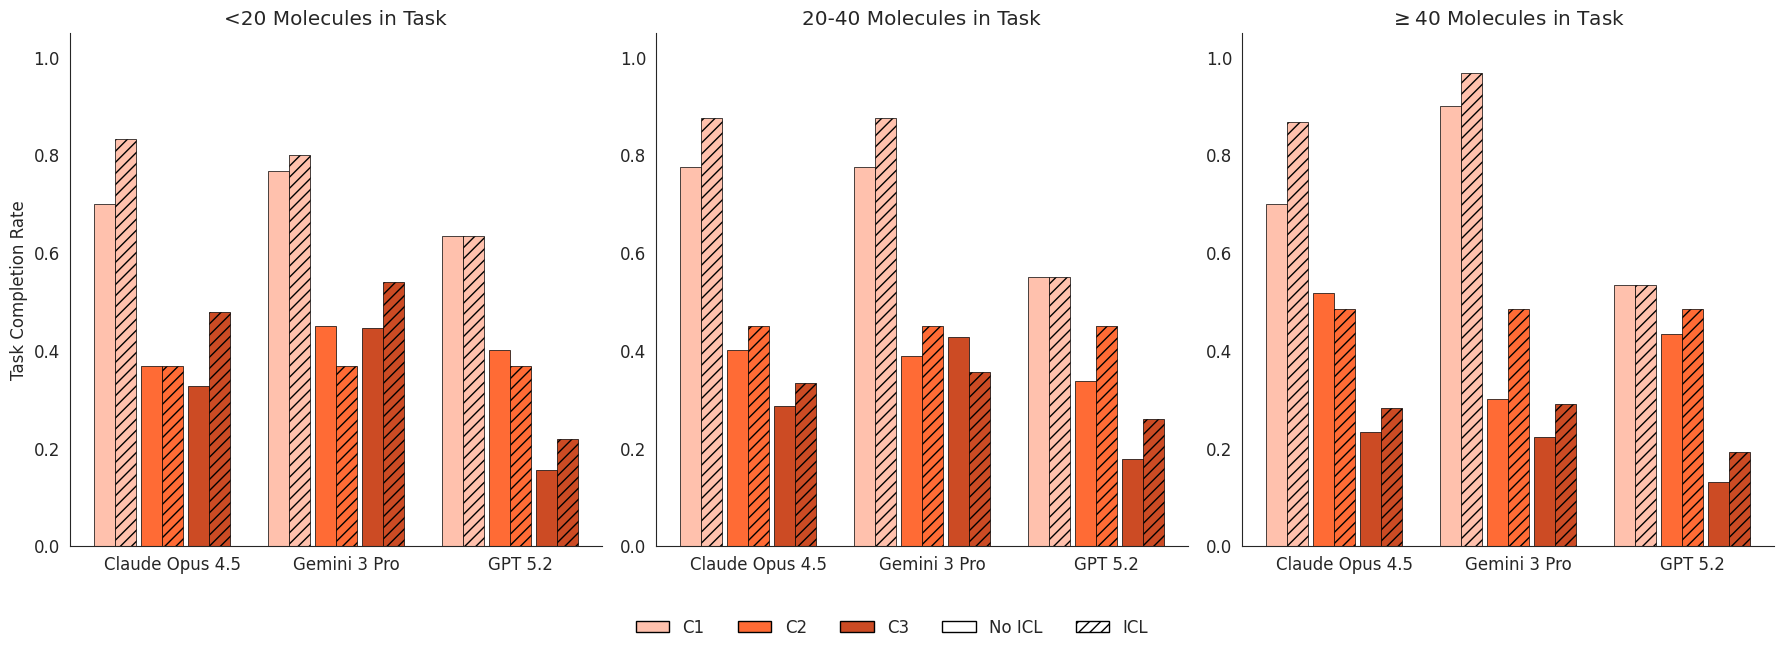


Plot saved to: plots/icl_vs_no_icl_comparison.png


In [33]:
# Create the final comparison plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define hatching patterns
hatches = {'No ICL': '', 'ICL': '///'}

for i, n_mol_bin in enumerate(['<20', '20-40', '>=40']):
    ax = axes[i]
    
    # Filter data for this bin
    bin_data = all_task_results[all_task_results['n_mol_bin'] == n_mol_bin].copy()
    
    if len(bin_data) == 0:
        print(f"Warning: No data for bin {n_mol_bin}")
        continue
    
    # Create grouped bar plot
    # We need to manually create the bars to control colors and hatching
    models = sorted(bin_data['Model'].unique())
    tasks = ['C1', 'C2', 'C3']
    icl_statuses = ['No ICL', 'ICL']
    
    x = np.arange(len(models))  # Model positions
    width = 0.12  # Width of each bar
    gap_between_tasks = 0.03  # Small gap between task groups
    
    # Plot bars for each task and ICL status
    for task_idx, task in enumerate(tasks):
        for icl_idx, icl_status in enumerate(icl_statuses):
            # Get data for this combination
            subset = bin_data[(bin_data['Task'] == task) & (bin_data['ICL'] == icl_status)]
            
            if len(subset) == 0:
                continue
            
            # Sort by model to ensure consistent ordering
            subset = subset.sort_values('Model')
            
            # Calculate position: each task group has 2 adjacent bars (No ICL + ICL)
            # with gaps between different tasks
            task_group_start = task_idx * (2 * width + gap_between_tasks)
            total_width = len(tasks) * 2 * width + (len(tasks) - 1) * gap_between_tasks
            offset = task_group_start + icl_idx * width - total_width / 2
            
            # Plot bars
            bars = ax.bar(
                x + offset,
                subset['Task Completion'],
                width,
                label=f"{task} - {icl_status}" if i == 0 else None,
                color=custom_colors[task_idx],
                hatch=hatches[icl_status],
                edgecolor='black',
                linewidth=0.5
            )
    
    # Formatting
    ax.set_ylabel('Task Completion Rate' if i == 0 else '')
    ax.set_xlabel('')
    ax.set_xticks(x)
    ax.set_xticklabels([
        "Claude Opus 4.5",
        "Gemini 3 Pro",
        "GPT 5.2"
    ])
    ax.set_ylim([0, 1.05])
    
    # Title
    title = f'{n_mol_bin} Molecules in Task'
    if n_mol_bin == '>=40':
        title = '$\\geq 40$ Molecules in Task'
    ax.set_title(title)
    
    sns.despine(ax=ax)

# Create custom legend
from matplotlib.patches import Patch
legend_elements = []
for task_idx, task in enumerate(['C1', 'C2', 'C3']):
    legend_elements.append(Patch(facecolor=custom_colors[task_idx], edgecolor='black', label=task))
legend_elements.append(Patch(facecolor='white', edgecolor='black', label='No ICL'))
legend_elements.append(Patch(facecolor='white', edgecolor='black', hatch='///', label='ICL'))

fig.legend(handles=legend_elements, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.1), frameon=False)

plt.tight_layout()
plt.savefig('plots/icl_vs_no_icl_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved to: plots/icl_vs_no_icl_comparison.png")

## Summary Statistics

In [31]:
# Create summary table showing improvement from ICL
print("\n" + "="*100)
print("ICL IMPACT SUMMARY: Improvement in Task Completion Rates")
print("="*100)

summary_rows = []

for task in ['C1', 'C2', 'C3']:
    for model in sorted(all_task_results['Model'].unique()):
        for n_mol_bin in ['<20', '20-40', '>=40']:
            # Get No ICL and ICL values
            no_icl_subset = all_task_results[
                (all_task_results['Task'] == task) & 
                (all_task_results['Model'] == model) & 
                (all_task_results['n_mol_bin'] == n_mol_bin) & 
                (all_task_results['ICL'] == 'No ICL')
            ]
            
            icl_subset = all_task_results[
                (all_task_results['Task'] == task) & 
                (all_task_results['Model'] == model) & 
                (all_task_results['n_mol_bin'] == n_mol_bin) & 
                (all_task_results['ICL'] == 'ICL')
            ]
            
            if len(no_icl_subset) > 0 and len(icl_subset) > 0:
                no_icl = no_icl_subset['Task Completion'].values[0]
                icl = icl_subset['Task Completion'].values[0]
                improvement = icl - no_icl
                pct_change = (improvement / no_icl * 100) if no_icl > 0 else 0
                
                summary_rows.append({
                    'Task': task,
                    'Model': model,
                    'N_Mol_Bin': n_mol_bin,
                    'No ICL': f"{no_icl:.3f}",
                    'ICL': f"{icl:.3f}",
                    'Δ': f"{improvement:+.3f}",
                    'Δ%': f"{pct_change:+.1f}%"
                })

if summary_rows:
    summary_table = pd.DataFrame(summary_rows)
    print(summary_table.to_string(index=False))
    
    # Export to CSV
    Path('analysis_results').mkdir(exist_ok=True)
    summary_table.to_csv('analysis_results/icl_impact_summary.csv', index=False)
    print("\nSummary table exported to: analysis_results/icl_impact_summary.csv")
else:
    print("No data available for summary")


ICL IMPACT SUMMARY: Improvement in Task Completion Rates
Task                Model N_Mol_Bin No ICL   ICL      Δ     Δ%
  C1      claude-opus-4-5       <20  0.700 0.833 +0.133 +19.0%
  C1      claude-opus-4-5     20-40  0.775 0.875 +0.100 +12.9%
  C1      claude-opus-4-5      >=40  0.700 0.867 +0.167 +23.8%
  C1 gemini-3-pro-preview       <20  0.767 0.800 +0.033  +4.3%
  C1 gemini-3-pro-preview     20-40  0.775 0.875 +0.100 +12.9%
  C1 gemini-3-pro-preview      >=40  0.900 0.967 +0.067  +7.4%
  C1              gpt-5.2       <20  0.633 0.633 +0.000  +0.0%
  C1              gpt-5.2     20-40  0.550 0.550 +0.000  +0.0%
  C1              gpt-5.2      >=40  0.533 0.533 +0.000  +0.0%
  C2      claude-opus-4-5       <20  0.367 0.367 +0.000  +0.0%
  C2      claude-opus-4-5     20-40  0.400 0.450 +0.050 +12.5%
  C2      claude-opus-4-5      >=40  0.517 0.483 -0.033  -6.5%
  C3      claude-opus-4-5       <20  0.326 0.477 +0.151 +46.3%
  C3      claude-opus-4-5     20-40  0.287 0.332 +0.046 +15.

In [32]:
# Overall improvement summary (averaged across all bins)
print("\n" + "="*80)
print("OVERALL ICL IMPACT (averaged across all molecule count bins)")
print("="*80)

for task in ['C1', 'C2', 'C3']:
    print(f"\n{task}:")
    for model in sorted(all_task_results['Model'].unique()):
        no_icl_mean = all_task_results[
            (all_task_results['Task'] == task) & 
            (all_task_results['Model'] == model) & 
            (all_task_results['ICL'] == 'No ICL')
        ]['Task Completion'].mean()
        
        icl_mean = all_task_results[
            (all_task_results['Task'] == task) & 
            (all_task_results['Model'] == model) & 
            (all_task_results['ICL'] == 'ICL')
        ]['Task Completion'].mean()
        
        if not np.isnan(icl_mean) and not np.isnan(no_icl_mean):
            improvement = icl_mean - no_icl_mean
            pct_change = (improvement / no_icl_mean * 100) if no_icl_mean > 0 else 0
            print(f"  {model}:")
            print(f"    No ICL: {no_icl_mean:.3f}")
            print(f"    ICL:    {icl_mean:.3f}")
            print(f"    Δ:      {improvement:+.3f} ({pct_change:+.1f}%)")


OVERALL ICL IMPACT (averaged across all molecule count bins)

C1:
  claude-opus-4-5:
    No ICL: 0.725
    ICL:    0.858
    Δ:      +0.133 (+18.4%)
  gemini-3-pro-preview:
    No ICL: 0.814
    ICL:    0.881
    Δ:      +0.067 (+8.2%)
  gpt-5.2:
    No ICL: 0.572
    ICL:    0.572
    Δ:      +0.000 (+0.0%)

C2:
  claude-opus-4-5:
    No ICL: 0.428
    ICL:    0.433
    Δ:      +0.006 (+1.3%)

C3:
  claude-opus-4-5:
    No ICL: 0.282
    ICL:    0.364
    Δ:      +0.082 (+29.0%)
  gemini-3-pro-preview:
    No ICL: 0.365
    ICL:    0.395
    Δ:      +0.030 (+8.2%)
  gpt-5.2:
    No ICL: 0.155
    ICL:    0.223
    Δ:      +0.069 (+44.4%)
